# Task Description

A taxi company named Sweet Lift has collected historical data on taxi orders at the airport. As a Data Scientist, I have been asked to create a model that can predict the number of taxi orders for the next hour with the hope of attracting more drivers during peak hours. The evaluation metric RMSE on the test set should not be more than 48.

## Task Instruction

1. Download the data and perform resampling into hourly intervals.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the original dataset.
4. Test the data using the test sample and draw conclusions.

## Data Description

The data is stored in the file taxi.csv. The number of orders is in the column 'num_orders'.

## Preparation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

### Initial Data Exploration

In [ ]:
# load file into dataframe
df = pd.read_csv('/datasets/taxi.csv',
                 index_col = [0],
                 parse_dates = [0])

In [ ]:
# Sort data based on datetime
df.sort_index(inplace = True)
df.index.is_monotonic

True

In [ ]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df.tail(5)

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<AxesSubplot:xlabel='datetime'>

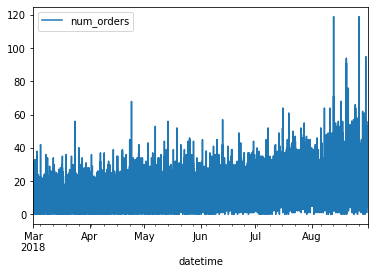

In [ ]:
df.plot()

The data available is from March 1st, 2018 at 00:00 to August 31st, 2018 at 23:50 with a 10-minute interval. After plotting, it turns out that we cannot see any trends or seasonality in the data, so data resampling needs to be done.

In [ ]:
# Resample data
df_hour = df.resample('1H').sum()
df_day = df.resample('1D').sum()

### Features Engineering

In [ ]:
# Time Features

df_hour['month'] = df_hour.index.month
df_hour['day'] = df_hour.index.day
df_hour['day_of_week'] = df_hour.index.dayofweek
df_hour['hour'] = df_hour.index.hour

In [ ]:
# Lag Features

df_hour['lag1'] = df_hour['num_orders'].shift(1)
df_hour['lag2'] = df_hour['num_orders'].shift(2)
df_hour['lag3'] = df_hour['num_orders'].shift(3)

In [ ]:
# Rolling Features

df_hour['rolling_mean_null'] = df_hour['num_orders'].rolling(2).mean()
df_hour['rolling_mean'] = df_hour['num_orders'].rolling(2, min_periods = 1).mean()
df_hour['rolling_sum'] = df_hour['num_orders'].rolling(2, min_periods = 1).sum()

In [ ]:
# Expanding Features

df_hour['expanding_mean'] = df_hour['num_orders'].expanding(2).mean()
df_hour['expanding_sum'] = df_hour['num_orders'].expanding(2).sum()

**Brief Summary:**

In the preparation section, I checked the data, resampled the data, and performed feature engineering. In the next section, I will examine trend and seasonal graphs and determine which features are strongly correlated with the target.

## Analsys

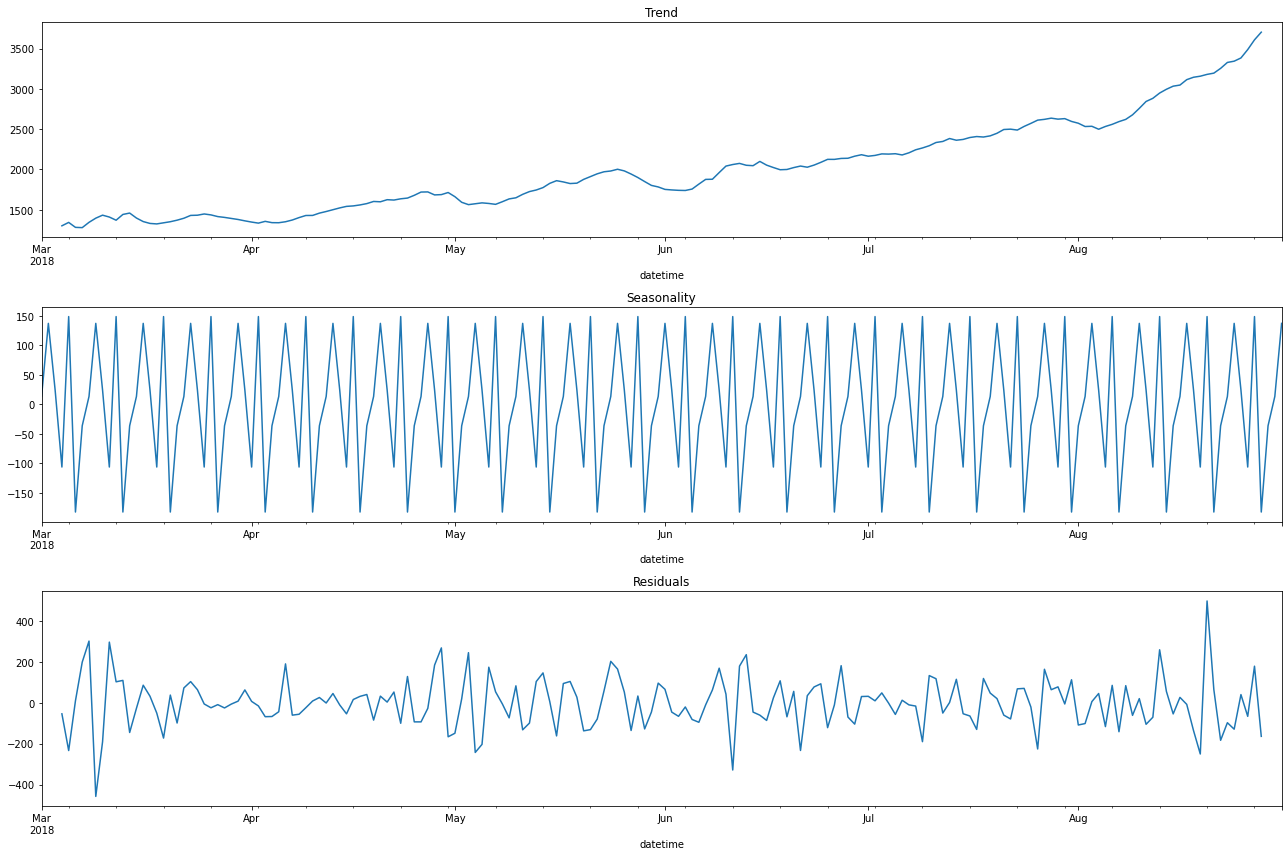

In [ ]:
# Tren and Seasonal (Full Data)
decomposed = seasonal_decompose(df_day['num_orders'])

plt.figure(figsize=(18, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')
plt.tight_layout()

Based on the visualization, it can be seen that the demand for taxis from March to August continues to increase with a trend that tends to fluctuate on a daily basis.

In [ ]:
# Define corr variable
corr = df_hour.corr()

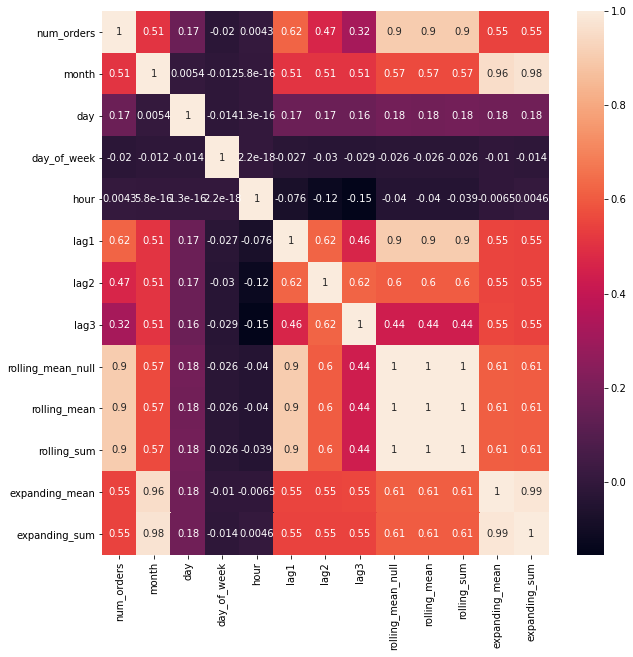

In [ ]:
# Visualize Correlation using Heatmap
plt.figure(figsize = (10, 10))
sns.heatmap(corr, annot=True)
plt.show()

In [ ]:
# Drop column
df_hour = df_hour.drop(['month', 'day', 'day_of_week', 'hour'], axis=1)

In [ ]:
# Drop null data
df_hour = df_hour.dropna()

**Brief Summary:**

Based on the visualization, it can be seen that the 'month', 'day', and 'day_of_week' columns have a very low correlation level with the target column, so I decided to drop those columns in order to improving the speed of the model's prediction.

## Model Train

### Features and Target Preparation

In [ ]:
# define features and target
features = df_hour.drop(['num_orders'], axis=1)
target = df_hour['num_orders']

In [ ]:
# split data into 2 datasets
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle = False, test_size = 0.1, random_state = 12345)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3971, 8)
(442, 8)
(3971,)
(442,)


In [ ]:
# scale data
feature_names = ['lag1', 'lag2', 'lag3', 'rolling_mean_null', 'rolling_mean',
                 'rolling_sum', 'expanding_mean', 'expanding_sum']
transformer_mas = StandardScaler().fit(features_train[feature_names].to_numpy())

features_train_scaled = features_train.copy()
features_train_scaled.loc[:, feature_names] = transformer_mas.transform(features_train[feature_names].to_numpy())
features_test_scaled = features_test.copy()
features_test_scaled.loc[:, feature_names] = transformer_mas.transform(features_test[feature_names].to_numpy())

### RandomForest

In [ ]:
start_rf = time.process_time()
model_rf = RandomForestRegressor(random_state = 12345)
model_rf.fit(features_train_scaled, target_train)
predictions_valid_rf = model_rf.predict(features_test_scaled)

rf_rmse = (mean_squared_error(target_test, predictions_valid_rf))**0.5
end_rf = time.process_time()
rf_time = round(end_rf-start_rf,2)
print("Random Forest RMSE:", rf_rmse)
print(f'Processing time for Random Forest = {rf_time}')

Random Forest RMSE: 19.578123110372122
Processing time for Random Forest = 2.1


In [ ]:
# Hyperparameter_tunning for Random Forest
param_grid = {'n_estimators': [100, 150, 200],
              'max_depth': [3, 5, 10],
              'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state = 12345)

grid = GridSearchCV(estimator = rf,
                    param_grid = param_grid,
                    cv = 5, scoring='neg_root_mean_squared_error')

grid.fit(features_train_scaled, target_train)
predictions_valid = grid.predict(features_test_scaled)
rmse = (mean_squared_error(target_test, predictions_valid))**0.5

print("The best paramenets are %s with a score of %0.2f"%
      (grid.best_params_,grid.best_score_))
print("Random Forest RMSE:", rmse)

The best paramenets are {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200} with a score of -6.84
Random Forest RMSE: 21.204561344047807


### LightGBM

In [ ]:
start_lgbm = time.process_time()
model_lgbm = LGBMRegressor(random_state = 12345)
model_lgbm.fit(features_train_scaled, target_train)
predictions_valid_lgbm = model_lgbm.predict(features_test_scaled)

lgbm_rmse = (mean_squared_error(target_test, predictions_valid_lgbm))**0.5
end_lgbm = time.process_time()
lgbm_time = round(end_lgbm-start_lgbm,2)
print("LightGBM RMSE:", lgbm_rmse)
print(f'Processing time for LightGBM = {lgbm_time}')

LightGBM RMSE: 26.919138586861614
Processing time for LightGBM = 0.39


In [ ]:
# Hyperparameter_tunning for LightGBM
param_grid = {'n_estimators': [50, 100, 150],
              'max_depth': [3, 5, 10],
              'learning_rate': [0.1, 0.01]
}

lgbm = LGBMRegressor(random_state = 12345)

grid = GridSearchCV(estimator = lgbm,
                    param_grid = param_grid,
                    cv = 5, scoring= 'neg_root_mean_squared_error')

grid.fit(features_train_scaled, target_train)
predictions_valid = grid.predict(features_test_scaled)
rmse = (mean_squared_error(target_test, predictions_valid))**0.5

print("The best paramenets are %s with a score of %0.2f"%
      (grid.best_params_,grid.best_score_))
print("LightGBM RMSE:", rmse)

The best paramenets are {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100} with a score of -4.90
LightGBM RMSE: 27.028468258744216


### CatBoost

In [ ]:
start_cat = time.process_time()
model_cat = CatBoostRegressor(random_state = 12345)
model_cat.fit(features_train_scaled, target_train, verbose = 100)
predictions_valid_cat = model_cat.predict(features_test_scaled)

cat_rmse = (mean_squared_error(target_test, predictions_valid_cat))**0.5
end_cat = time.process_time()
cat_time = round(end_cat-start_cat,2)
print("CatBoost RMSE:", cat_rmse)
print(f'Processing time for CatBoost = {cat_time}')

Learning rate set to 0.05091
0:	learn: 37.3052523	total: 4.85ms	remaining: 4.85s
100:	learn: 7.4988771	total: 327ms	remaining: 2.91s
200:	learn: 4.0827310	total: 629ms	remaining: 2.5s
300:	learn: 2.2294536	total: 901ms	remaining: 2.09s
400:	learn: 1.4478033	total: 1.17s	remaining: 1.74s
500:	learn: 1.1122511	total: 1.44s	remaining: 1.43s
600:	learn: 0.9091592	total: 1.77s	remaining: 1.17s
700:	learn: 0.7903085	total: 2.13s	remaining: 910ms
800:	learn: 0.7038152	total: 2.52s	remaining: 626ms
900:	learn: 0.6434682	total: 2.81s	remaining: 309ms
999:	learn: 0.5878768	total: 3.14s	remaining: 0us
CatBoost RMSE: 30.851388822863242
Processing time for CatBoost = 3.19


In [ ]:
# Hyperparameter_tunning for CatBoost
param_grid = {'iterations': [100, 150, 200],
              'depth': [3, 5, 10],
              'learning_rate': [0.1, 0.01]
}

cat = CatBoostRegressor(random_state = 12345)

grid = GridSearchCV(estimator = cat,
                    param_grid = param_grid,
                    cv = 5, scoring='neg_root_mean_squared_error')

grid.fit(features_train_scaled, target_train, verbose = 50)
predictions_valid = grid.predict(features_test_scaled)
rmse = (mean_squared_error(target_test, predictions_valid))**0.5

print("The best paramenets are %s with a score of %0.2f"%
      (grid.best_params_,grid.best_score_))
print("CatBoost RMSE:", rmse)

0:	learn: 36.5224046	total: 1.13ms	remaining: 112ms
50:	learn: 11.6258452	total: 53ms	remaining: 50.9ms
99:	learn: 7.0412356	total: 109ms	remaining: 0us
0:	learn: 36.9503653	total: 1.27ms	remaining: 126ms
50:	learn: 11.4975504	total: 51.4ms	remaining: 49.3ms
99:	learn: 6.9782190	total: 101ms	remaining: 0us
0:	learn: 37.1586973	total: 1.49ms	remaining: 147ms
50:	learn: 11.7922607	total: 52.7ms	remaining: 50.6ms
99:	learn: 7.3773526	total: 98.5ms	remaining: 0us
0:	learn: 37.1304545	total: 1.62ms	remaining: 160ms
50:	learn: 11.6147083	total: 73.3ms	remaining: 70.5ms
99:	learn: 7.2809105	total: 138ms	remaining: 0us
0:	learn: 32.1062412	total: 1.13ms	remaining: 112ms
50:	learn: 8.8012390	total: 48.5ms	remaining: 46.6ms
99:	learn: 4.7441731	total: 91.3ms	remaining: 0us
0:	learn: 38.6565373	total: 1.1ms	remaining: 109ms
50:	learn: 29.2118668	total: 55ms	remaining: 52.8ms
99:	learn: 23.9127630	total: 107ms	remaining: 0us
0:	learn: 39.1491399	total: 1.12ms	remaining: 111ms
50:	learn: 29.3799339

### Model Performance Comparison

In [ ]:
comparison = pd.DataFrame(
    {'Model RMSE' : [rf_rmse, lgbm_rmse, cat_rmse],
    'Processing Time' : [rf_time, lgbm_time, cat_time]},
    index = ['RandomForest', 'LightGBM', 'CatBoost'])
comparison

,Model RMSE,Processing Time
RandomForest,19.578123,2.10
LightGBM,26.919139,0.39
CatBoost,30.851389,3.19


In [ ]:
# define df_train and df_target
df_train = features_train.join(target_train, how='inner')
df_test = features_test.join(target_test, how='inner')

**Brief Summary:**

From the 3 models created, RandomForest is the model with the lowest RMSE value (19) and LightGBM is the model with the lowest processing time (0.39 seconds). Therefore, I have decided to use two models in the testing phase, namely RandomForest and LightGBM.

## Pengujian

In [ ]:
# Train new Random Forest model using tuned hyperparameters
start_rf = time.process_time()
model_rf = RandomForestRegressor(n_estimators = 200,
                                 max_depth = 10,
                                 max_features = 'log2',
                                 random_state = 12345)
model_rf.fit(features_train_scaled, target_train)
predictions_valid_rf = model_rf.predict(features_test_scaled)

rf_rmse = (mean_squared_error(target_test, predictions_valid_rf))**0.5
end_rf = time.process_time()
rf_time = round(end_rf-start_rf,2)
print("Random Forest RMSE:", rf_rmse)
print(f'Processing time for Random Forest = {rf_time}')

Random Forest RMSE: 21.204561344047807
Processing time for Random Forest = 1.63


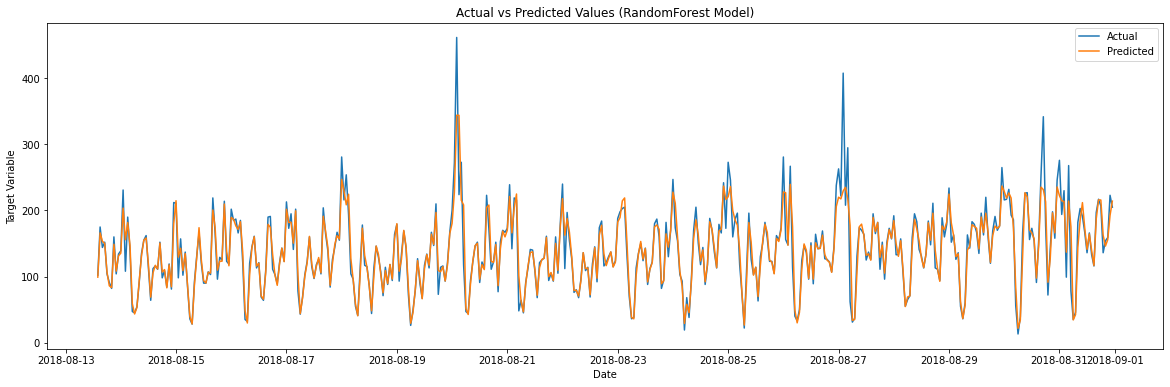

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(target_test.index, target_test, label='Actual')
ax.plot(target_test.index, predictions_valid_rf, label='Predicted')
ax.set_title('Actual vs Predicted Values (RandomForest Model)')
ax.set_xlabel('Date')
ax.set_ylabel('Target Variable')
ax.legend()

plt.show()

In [ ]:
# Train new LightGBM model using tuned hyperparameters
start_lgbm = time.process_time()
model_lgbm = LGBMRegressor(n_estimators = 100,
                           max_depth = 10,
                           learning_rate = 0.1,
                           random_state = 12345)
model_lgbm.fit(features_train_scaled, target_train)
predictions_valid_lgbm = model_lgbm.predict(features_test_scaled)

lgbm_rmse = (mean_squared_error(target_test, predictions_valid_lgbm))**0.5
end_lgbm = time.process_time()
lgbm_time = round(end_lgbm-start_lgbm,2)
print("LightGBM RMSE:", lgbm_rmse)
print(f'Processing time for LightGBM = {lgbm_time}')

LightGBM RMSE: 27.028468258744216
Processing time for LightGBM = 0.41


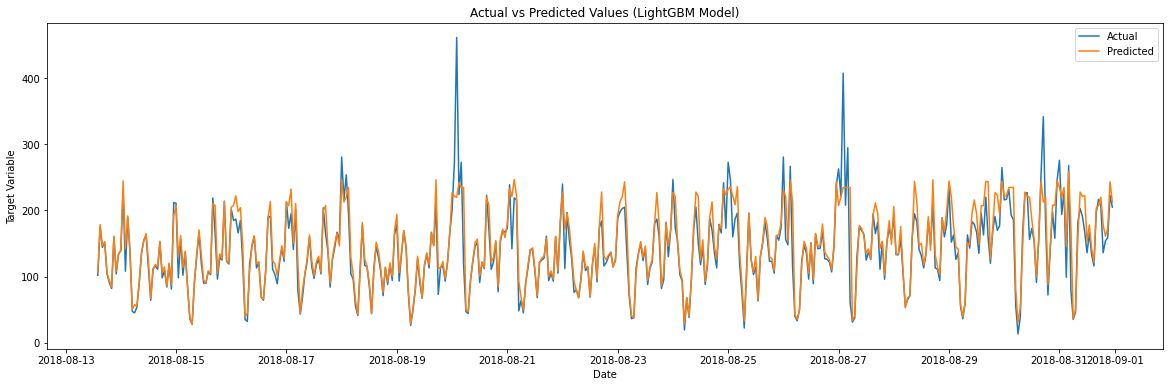

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(target_test.index, target_test, label='Actual')
ax.plot(target_test.index, predictions_valid_lgbm, label='Predicted')
ax.set_title('Actual vs Predicted Values (LightGBM Model)')
ax.set_xlabel('Date')
ax.set_ylabel('Target Variable')
ax.legend()

plt.show()

**Conslusion:**

Based on the results of creating models using RandomForest, LightGBM, and CatBoost, it can be concluded that the RandomForest model produces the best prediction performance among the three models with an RMSE value of 21.2 and processing speed of 1.63 seconds, while the LightGBM model has the fastest processing speed at 0.41 seconds and an RMSE value of 27.

Therefore, I recommend that Sweet Lift company use the RandomForest model to predict the number of taxi orders for the next hour. The model with a higher RMSE value was chosen to balance the needs of customers with the availability of the fleet, with the hope of improving service for customer satisfaction.